<!--NAVIGATION-->
< [深入：流形学习](05.10-Manifold-Learning.ipynb) | [目录](Index.ipynb) | [深入：高斯混合模型](05.12-Gaussian-Mixtures.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.11-K-Means.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# In Depth: k-Means Clustering

# 深入：K均值聚类

> In the previous few sections, we have explored one category of unsupervised machine learning models: dimensionality reduction.
Here we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

在前面两节中，我们研究了无监督机器学习的一个大类：降维。下面我们将要继续讨论无监督机器学习的另一个大类：聚类算法。聚类算法寻求通过数据的属性进行学习，然后获得数据点的优化分组或离散标签。

> Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in ``sklearn.cluster.KMeans``.

许多聚类算法在Scikit-Learn和其他包中都实现了，其中最容易理解的算法就是*k均值聚类*，它被实现在`sklearn.cluster.KMeans`包中。

> We begin with the standard imports:

例行导入包：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # 图表风格 seaborn
import numpy as np

## Introducing k-Means

## k均值聚类简介

> The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

> - The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

K均值是一个在未标记的多维数据集中寻找确定分组数聚类的算法。该算法基于下述的优化聚类的基本概念：

- “聚类中心”是该聚类所有点的算术平均。
- 每一个数据点距离它所属的聚类中心比距离其他聚类中心都要近。

> Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

这两个假设是k均值模型的基本原理。我们很快会了解算法是*如何*达到这个目标的，但是现在首先让我们使用一个简单的数据集来查看k均值的结果。

> First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

首先，让我们生成一个二维的数据集，内含四个独立的群落。为了强调这是一个无监督算法，我们在图中没有展示标签：

译者注：下面代码为适应新版scikit-learn去除了`sample_generator`模块以避免产生警告。

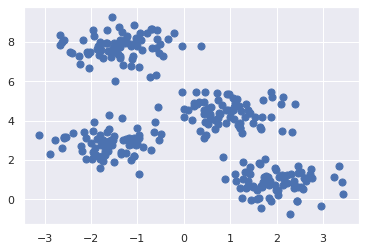

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

> By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

通过肉眼观察很容易能分出四个聚类出来。k均值算法会自动完成这个工作，在Scikit-Learn中有专门的评估器API：

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

> Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

然后将模型预测的结果使用不同的颜色绘制在图中。同时我们也会在图中画出每个聚类的中心点，这个中心点是评估器计算得到的：

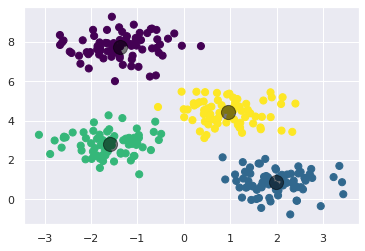

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

> The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

可以看到k均值算法（至少在这个简单的例子当中）对数据点聚类的方法与肉眼方式相似。但是你可能会疑惑为什么算法能这么快找出所有的聚类。因为由简单的数学可知，聚类的可能数量是数据点数量的指数量级。如果穷举所有的可能性的话，那将会非常非常慢。幸运的是，我们并不需要这样的穷举：可以使用一种被称为最大期望算法的直观迭代方法来实现k均值算法。

## k-Means Algorithm: Expectation–Maximization

## k均值算法：最大期望算法

> Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

>1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 
   
最大期望算法（E-M）是在数据科学领域广泛应用的强大算法。其中k均值是该算法最简单和易于理解的应用场景，这里简要介绍一下，最大期望算法的步骤如下：

1. 随机猜测聚类中心点
2. 重复以下步骤
    1. *E步骤*：将所有数据点分配到最近的聚类中心点上
    2. *M步骤*：重新计算每个聚类的中心点

> Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

这里的“E步骤”也叫“期望步骤”，名字的由来是因为它是处理每个数据点归属的聚类的，即我们的期望。“M步骤”也叫“最大化步骤”，它的名字由来是因为用来最大化定义聚类中心点的适配函数的，在这个情况中，最大化过程实际上就是对每个聚类的数据点取均值。

> The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

要详细描述整个算法可能会很冗长，但是可以用一句话进行概括：在典型情况下，每次E步骤和M步骤的迭代都会导致更加准确的聚类特征结果。

> We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
For an interactive version of this figure, refer to the code in [the Appendix](06.00-Figure-Code.ipynb#Interactive-K-Means).

我们可以用下面图像可视化这个算法过程。对于一个左边图中设定的初始化中心点的情况，算法仅需要三次迭代的过程就可以完成聚类结果。如果想要这个图像的交互式版本，请参考[附录](06.00-Figure-Code.ipynb#Interactive-K-Means)中的代码。

![(run code in Appendix to generate image)](figures/05.11-expectation-maximization.png)
[附录中生成图像的代码](06.00-Figure-Code.ipynb#Expectation-Maximization)

> The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

k均值算法很简单，我们可以使用数行代码就能实现它。下面是一种最基本的实现方式：

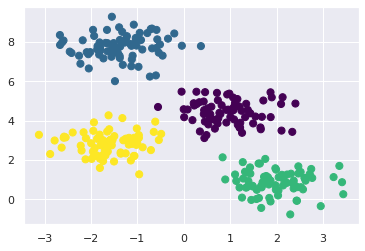

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. 随机选取聚类中心点
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. 计算求出距离最近的中心点，标记相应数据点
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. 求出每个聚类最新的中心点
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. 检查收敛，如果新中心点与原中心点相同，算法结束
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

当然存在很多良好测试的实现方式会比上面的函数更加健壮，但是上面的代码给出了最大期望算法的纲要。

### Caveats of expectation–maximization

### 最大期望算法的一些注意事项

> There are a few issues to be aware of when using the expectation–maximization algorithm.

在使用最大期望算法时，有一些注意事项需要留意。

#### The globally optimal result may not be achieved

#### 全局最优解可能不可得

> First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

首先，虽然E-M算法能保证每次迭代都改善结果，但是它并不能保证最终会产生全局最优解。例如，如果我们使用了不同的随机种子，这个初始化值可能会产生不良的结果：

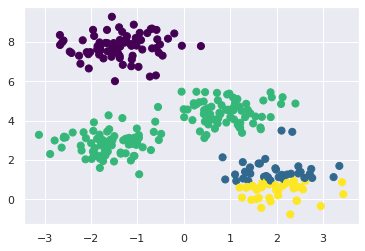

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

上面例子中E-M算法已经收敛了，但是没有收敛到一个全局最优的结果上。因此，该算法需要在不同的初始化条件下运行多次，而事实上Scikit-Learn默认就会这样做（设置`n_init`参数，默认为10）。

#### The number of clusters must be selected beforehand

#### 聚类的数量必须预先选择

> Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

k均值算法的另一个常见挑战是你必须告诉它聚类的个数：它并不能够从数据中学习得到聚类的数量。例如，如果我们要求算法计算6个聚类，它会很成功的运行得到相应的结果：

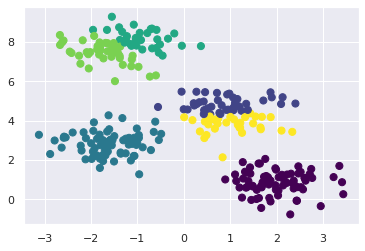

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

产生的结果是否有意义通常是一个难以准确回答的问题；有一种比较直观的方法可以回答这个问题，叫做[轮廓分析](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)，我们这里不会详述。

> Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [In Depth: Gaussian Mixture Models](05.12-Gaussian-Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the ``sklearn.cluster`` submodule)

还有其他的选择，你可以使用更加复杂的聚类算法，它们能提供更好的数值度量，如聚类的数量（例如，高斯混合模型，参见[深入：高斯混合模型](05.12-Gaussian-Mixtures.ipynb)），或者*能够*选择合适的聚类的数量（例如，密度聚类DBSCAN，均值漂移mean-shift或者亲和力传播affinity propagation，它们都实现在`sklearn.cluster`子模块中）。

#### k-means is limited to linear cluster boundaries

#### k均值只限于线性聚类边界

> The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

k均值的基本模型假设（数据点距离它所属的中心点比其他中心点都要近）意味着这个算法通常会在聚类有着复杂的集合结构的情况下失效。

> In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

严格来说，k均值算法聚类的边界总是线性的，因此在更复杂边界的情况下将无法使用。考虑下面的数据，然后使用k均值算法获得聚类结果：

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

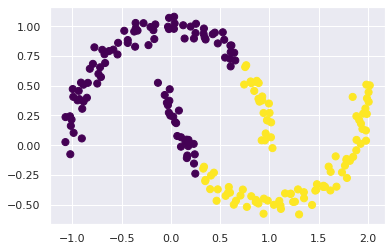

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> This situation is reminiscent of the discussion in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

这种情形让我们想起在[深入：支持向量机](05.07-Support-Vector-Machines.ipynb)中的讨论，我们可以使用核转换将数据投射到更高的维度上，令线性分类器可以工作。我们也可以在k均值算法上使用相同的技巧，令k均值能够支持非线性的边界。

> One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

这种核化的k均值算法其中一个版本是Scikit-Learn中实现的`SpectralClustering`评估器。它使用最近邻图像来计算更高维度的数据表示，然后使用k均值算法来标记数据点：

/home/wangy/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


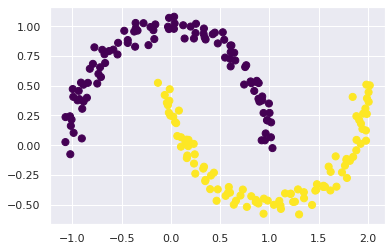

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

> We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

我们看到经过这种核转换方法后，核化的k均值算法能够实现更加复杂的非线性聚类边界。

#### k-means can be slow for large numbers of samples

#### k均值在大数据集上会慢

> Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use as we continue our discussion.

因为k均值算法上每次迭代都要获取数据集中的每个点，当样本量增加时，算法性能会下降。你可能会觉得是否每次迭代都有必要使用全部数据点；例如，每次迭代仅使用数据的一个子集来更新聚类中心点。这种想法就是基于批次的k均值算法，它被实现在`sklearn.cluster.MiniBatchKMeans`当中。批次算法的接口与标准k均值算法一致；接下来会看到一个例子。

## Examples

## 例子

> Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a wide variety of situations.
We'll now take a look at a couple examples.

当留意了上述的注意事项后，我们可以将k均值算法应用到广泛的场景中。下面我们看几个例子。

### Example 1: k-means on digits

### 例1：手写数字上应用k均值

> To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

首先，我们来看看在简单的手写数字数据集上应用k均值的情况，数据集与我们在[深入：随机森林](05.08-Random-Forests.ipynb)和[深入：主成分分析](05.09-Principal-Component-Analysis.ipynb)中看到的一样。不过我们将尝试不使用原始标签信息的情况下，应用k均值算法来分辨手写的数字；这情况就像我们在遇到一个没有任何初始标记的数据时，我们希望首先从中提取出有意义的信息一样。

> We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

当然我们需要载入数据然后找到其k均值聚类结果。回想一下，我们知道数据有1797个样本，每个样本有64个特征，这些特征代表着8×8图像中每个像素点的亮度：

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

就像前面那样，我们进行k均值聚类：

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

> The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

结果是在64维空间中的10个聚类。注意每个聚类的中心点都是64维空间中的一个点，我们可以将它们看做每个聚类的“典型”数字。让我们将这些中心点数字画出来：

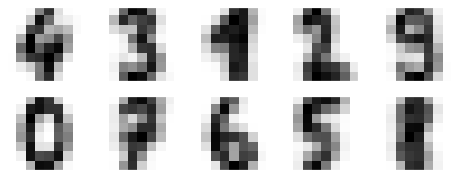

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

> We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

上面的结果表明，*甚至不需要标记*，`K均值`算法就已经能够分出聚类，并且它们的中心点都是可以识别的数字，可能1和8稍微模糊点。

> Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

因为k均值算法根本不知道这些聚类的标记，因此0-9的标签不是按照顺序排列的。我们可以将真实的标签和学习到的聚类标签进行对应：

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

> Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

现在我们可以检查这个无监督聚类算法结果的准确性了：

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7952142459654981

> With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

通过一个简单的k均值算法，我们就可以对80%左右的输入数据进行正确的分组。让我们再看看相应的混淆矩阵：

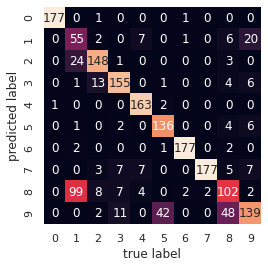

In [16]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

> As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

正如我们前面展示的聚类中心所预期到的那样，主要混淆的地方是在处在数字8和数字1之间。但是这还是能证明我们使用k均值就能构建一个分类器，而*不需要参考任何已知的标签*。

> Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding (t-SNE) algorithm (mentioned in [In-Depth: Manifold Learning](05.10-Manifold-Learning.ipynb)) to pre-process the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

为了更加有趣一点，我们再继续深入一点。我们使用t分布随机近邻嵌入（t-SNE）算法（参见[深入：流形学习](05.10-Manifold-Learning.ipynb)）在k均值算法之前来对数据进行预处理。t-SNE是一个非线性嵌入算法，特别适合用来保留聚类的数据点。让我们来看看怎么做：

In [17]:
from sklearn.manifold import TSNE

# 投射数据点，本步骤可能需要执行一段时间
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# 计算聚类
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# 排列标签
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# 计算准确率
accuracy_score(digits.target, labels)

0.9371174179187535

> That's nearly 92% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to do by hand or by eye.

这能在*不使用标签*的情况下达到超过93%的分类准确率。这体现了恰当的使用无监督学习方法的威力：它能从数据集中提取出关键信息，而这很难使用手工或肉眼完成。

### Example 2: *k*-means for color compression

### 例2：k均值进行颜色压缩

> One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

聚类还有一个有趣的应用是在图像的颜色压缩领域。例如设想你有一张图像包含一百万种颜色。在大多数图像中，大量的颜色都没有被用到，并且图像中很多的像素都有着相似甚至相同的颜色。

> For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

例如下面这张图像，是Scikit-Learn的`datasets`模块自带的（要使下面例子能成功运行，你需要安装`pillow`包）。

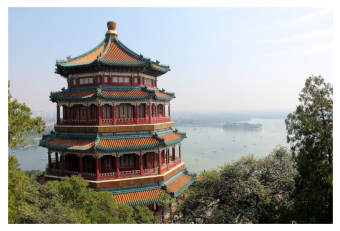

In [18]:
# 注：需要安装pillow包
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

> The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

这张图像存储在一个尺寸为`(高度, 宽度, RGB)`的三维数组之中，包含了红/蓝/绿的数值，取值范围是0-255：

In [19]:
china.shape

(427, 640, 3)

> One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

我们也可以将这张图像的像素看成是一个三维颜色空间中的数据点集合。下面我们将数组变形为`[n_samples x n_features]`形状，然后将颜色值转换为取值范围是0-1之间：

In [20]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

> We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

我们可以在这个颜色空间中将这些像素点可视化出来，为了效率起见，仅选择10000个像素的子数据集：

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # 选择随机子数据集
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

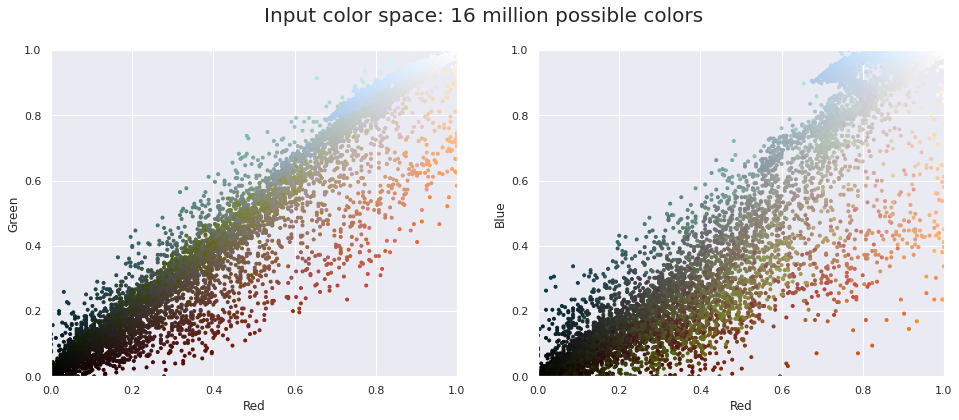

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

> Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

下面我们将1600万颜色调整为16色，仅仅需要在像素空间上使用k均值聚类算法。因为我们面对的是一个非常巨大的数据集，我们将会使用批次k均值算法，该算法每次迭代只会在数据子集上进行计算，比标准的k均值算法要快得多：

译者注：下面的warning已经被Numpy修复，因此代码中做了注释。

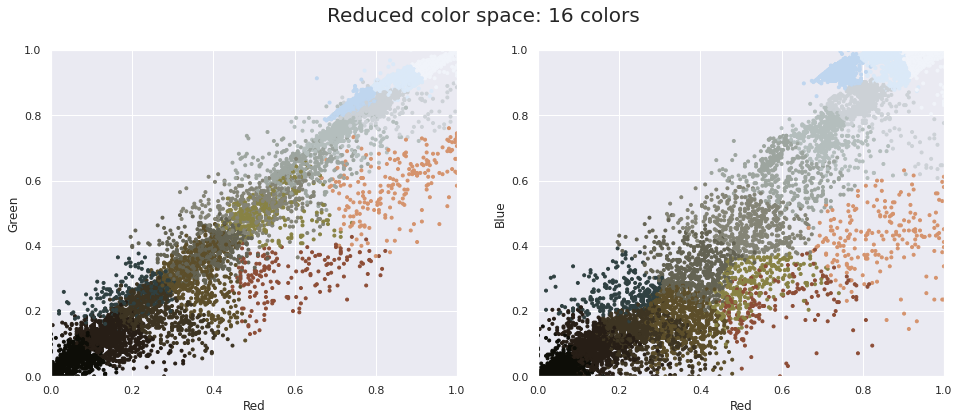

In [23]:
#import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

> The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

得到的结果是重新设置后的原始像素的颜色，也就是每个像素的颜色被设置成了它所属聚类的中心点值。将这些新设置颜色的像素转换回图像空间，然后展示出来：

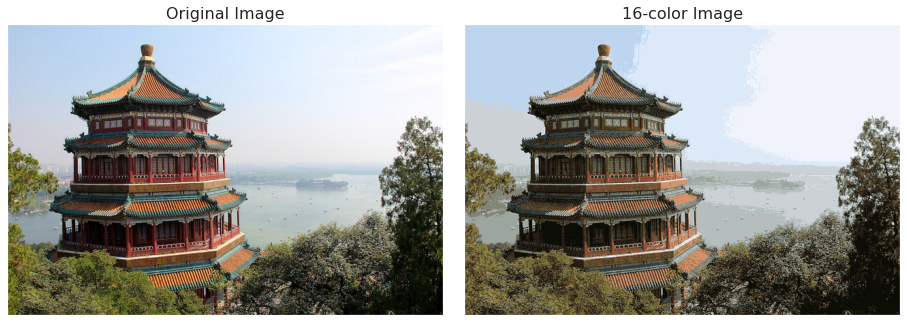

In [24]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

> Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

当然右图中损失了一些细节，但整体上图像还是很容易辨认的。运用这个方法右图获得了一个大约1百万的压缩比率。虽然这是k均值算法的一个有趣的应用场景，但是显然压缩图像信息还有更好的方法。这个例子为我们展现了类似k均值这样的无监督方法还能在一些意想之外的场景中发挥作用。

<!--NAVIGATION-->
< [深入：流形学习](05.10-Manifold-Learning.ipynb) | [目录](Index.ipynb) | [深入：高斯混合模型](05.12-Gaussian-Mixtures.ipynb) >

<a href="https://colab.research.google.com/github/wangyingsm/Python-Data-Science-Handbook/blob/master/notebooks/05.11-K-Means.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
